# Algoritmo de Grover

Este archivo ya puede buscar cada uno de los estados correspondientes a tres qubits.

### Importamos las herramientas necesarias:

In [274]:
import qiskit
from qiskit import *
from qiskit.visualization import plot_histogram
import math
from math import pi
import matplotlib
%matplotlib inline

### Banco de datos

Partimos de tener un banco de datos con N elementos en el que cada uno de estos está indexado con un número entero [0, N-1]. por simplicidad supondremos que N es una potencia de 2. En este ejemplo en particular se usará n=3. Es decir, los objetos en el banco de datos estarán indexados con las 3-tuplas de bits: 000, 001, 010, 011, 100, 101, 110 y 111.

Al igual que con el algoritmo de Deutsch-Josza, si se desea implementar el algoritmo de Grover para valores de n "grandes" (en este caso n>3), se necesitan compuertas controladas con más de 2 qubits de control.

# Definición de compuertas $U_{xxx}()$


Aplicando el razonamiento análogo a lo discutido en clase, y utilizando el resultado mencionado, se hará una compuerta CC-Z actuando sobre el qubit q2, controlada por los qubits q1 y q0. Puesto que los qubits q1 y q0 se encuentran en |0>, habrá que tomar esto en cuenta, modificando a |1> mediante una compuerta X (en cada qubit), y posteriormente anulando esta operación con otra compuerta X (en cada uno).

In [319]:
def uw_100(circuit):
    circuit.x(0)
    circuit.x(1)
    circuit.cu1(pi/2,1,2)
    circuit.cx(0,1)
    circuit.cu1(-pi/2,1,2)
    circuit.cx(0,1)
    circuit.cu1(pi/2,0,2)
    circuit.x(0)
    circuit.x(1)
    
def uw_011(circuit):
    circuit.x(2)
    circuit.cu1(pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(-pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(pi/2,2,0)
    circuit.x(2)
    
def uw_111(circuit):
    circuit.cu1(pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(-pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(pi/2,2,0)
    
def uw_000(circuit):
    circuit.x(range(0,n))
    circuit.cu1(pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(-pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(pi/2,2,0)
    circuit.x(range(0,n))
    
def uw_001(circuit):
    circuit.x(range(1,n))
    circuit.cu1(pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(-pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(pi/2,2,0)
    circuit.x(range(1,n))
    
def uw_110(circuit):
    circuit.x(0)
    circuit.cu1(pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(-pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(pi/2,2,0)
    circuit.x(0)

def uw_010(circuit):
    circuit.x(0)
    circuit.x(2)
    circuit.cu1(pi/2,2,1)
    circuit.cx(0,2)
    circuit.cu1(-pi/2,2,1)
    circuit.cx(0,2)
    circuit.cu1(pi/2,0,1)
    circuit.x(0)
    circuit.x(2)
    
def uw_101(circuit):
    circuit.x(1)
    circuit.cu1(pi/2,2,1)
    circuit.cx(0,2)
    circuit.cu1(-pi/2,2,1)
    circuit.cx(0,2)
    circuit.cu1(pi/2,0,1)
    circuit.x(1)

### Definición de la compuerta $U_s$

El algoritmo también requiere de la compuesrta $U_s = 2|s\rangle\langle s| - I$, la cual puede ser escrita (para n=1) como $U_s = H (2|0\rangle\langle 0| - I$) H. Es decir, podemos implementar Us con un operador que cambia el signo de todos los estados excepto el |000> entre compuertas Hadamard en cada qubit.

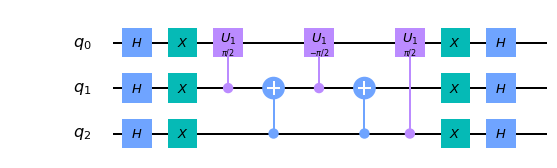

In [316]:
n=3
Us = QuantumCircuit(n)
def us(circuit):
    
    for i in range(0,n):
        circuit.h(i)
    
    for i in range(0,n):
        circuit.x(i)
    
    circuit.cu1(pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(-pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(pi/2,2,0)
    
    for i in range(0,n):
        circuit.x(i)
    
    for i in range(0,n):
        circuit.h(i)  
us(Us)
Us.draw(output = 'mpl')

### Construcción del circuito para el algoritmo de Grover
En el caso del algorimto de Grover (con n=3) requerimos 3 qubits y 3 bits clásicos para guardar los resultados de las mediciones.

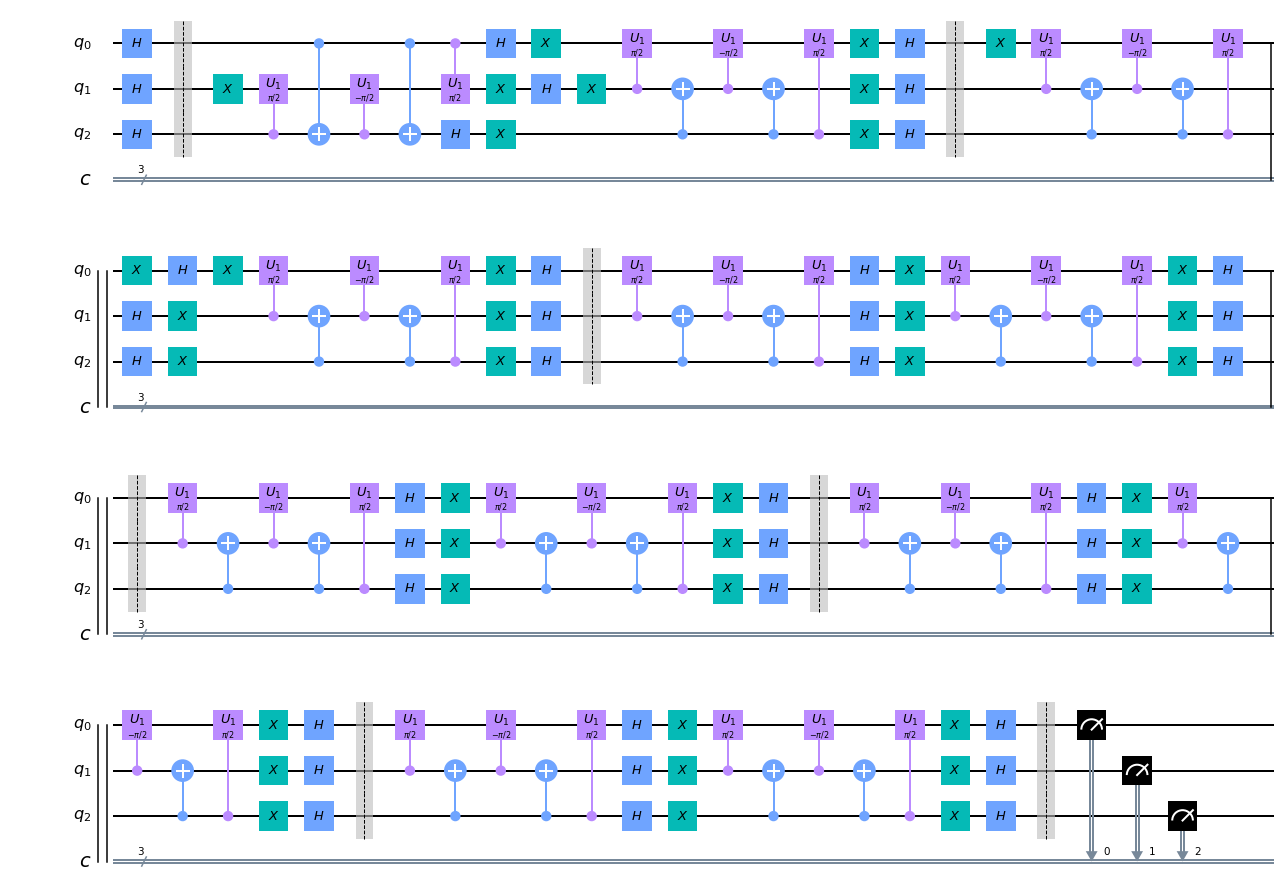

In [338]:
qc = QuantumCircuit(n,n)
# Superposición de todos los estados
for i in range(0,n):
    qc.h(i)
qc.barrier(range(0,n))

# 1ª iteración
uw_101(qc)
us(qc)
qc.barrier(range(0,n))
# 2ª iteración
uw_110(qc)
us(qc)
qc.barrier(range(0,n))

qc.measure(range(0,n),range(0,n))
qc.draw(output = 'mpl')

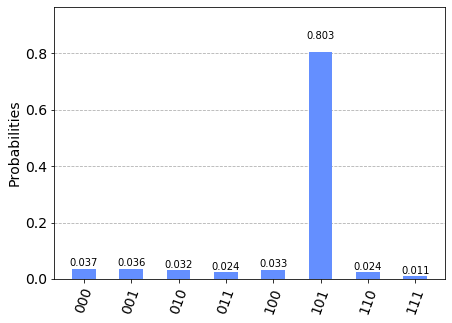

In [339]:
qasm = Aer.get_backend('qasm_simulator')
job = execute(qc, qasm, shots=1000)
result = job.result()
counts = result.get_counts(qc) 
plot_histogram(counts)

Ya sea que apliquemos la secuencia (Uw,Us) una o dos veces, el estado mas probable resulta ser el w=100. Al aplicar la secuencia dos veces, la probabilidad es considerablemente alta (95%), indicando que se ha encontrado el estado requerido.

### Implementación del algoritmo en las computadoras cuánticas de IBM

IBMQ.load_account()

In [1]:
IBMQ.load_account()

NameError: name 'IBMQ' is not defined

In [104]:
provider = IBMQ.get_provider('ibm-q')

In [44]:
qcomp = provider.get_backend('ibmq_vigo')

In [45]:
job = execute(qc, backend = qcomp, shots = 1024)

In [46]:
from qiskit.tools.monitor import job_monitor

In [47]:
job_monitor(job)

Job Status: job has successfully run


In [48]:
result = job.result()
counts2 = result.get_counts(qc)

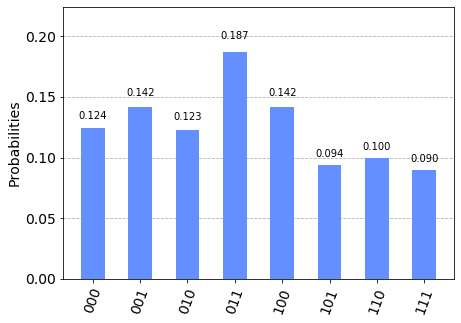

In [49]:
plot_histogram(counts2)

Al correr el algoritmo en una computadora cuántica real, la presencia de ruido no permite hallar el estado requerido.

Última modificación 27-06-20 por Bruno Ramírez